`run with high memory!`

In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [2]:
import plot_utils

In [3]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [4]:
model_identifier = 'gpt2-xl'
emb_context = 'Passage'
split_coord = "Sentence"
testonperturbed = True
randomnouns = False

In [5]:

CONDMAP = {
    'Original': f'original',
    #
    'Scr1': f'scrambled1',  # different for teston, there teston:scr1
    'Scr3': f'scrambled3',
    'Scr5': f'scrambled5',
    'Scr7': f'scrambled7',
    'backward': f'backward',
    'lowPMI': f'lowpmi',
    'lowPMI-random': f'lowpmi-random',
    #
    'contentwords': f'contentwords',
    'nounsverbsadj': f'nounsverbsadj',
    'nounsverbs': f'nounsverbs',
    'nouns': f'nouns',
    #'randomnouns': f'random-nouns',
    'functionwords': f'functionwords',
    #
    'chatgpt': f'chatgpt',
    'sentenceshuffle_passage': f'sent_passage',
    'sentenceshuffle_topic': f'sent_topic',
    'sentenceshuffle_random': f'sent_random',
    #
    'random-wl': f'random-wl'
}

In [6]:
def get_layers(model_identifier, which_layer="last"):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "identifier=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            
            if which_layer=="last":
                final_layer = layers[-1]
                return final_layer
            else:
                return layers
            break

In [7]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [8]:
from tqdm.notebook import tqdm

def get_dictionary(model_identifier, emb_context=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer (default: last_layer)
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    layer_identifier = get_layers(model_identifier, which_layer="last")

    print("This is the layer I'm looking at: ", layer_identifier)
    print(f"This is the emb_context={emb_context}")
    
    for cond in tqdm(CONDMAP.keys()):
        print(cond)
        for filename in tqdm(os.listdir(working_dir)):
            if f"identifier={model_identifier},stimuli_identifier=Pereira2018-{cond}-lasttoken,emb_context={emb_context}" in filename:
                passage_identifier = get_passage_identifier(filename)

                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data']
                data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]

                if not cond in model_dictionary:
                    model_dictionary[cond] = {}
                model_dictionary[cond][passage_identifier] = data
    
    return model_dictionary

In [9]:
model_activations_dictionary = get_dictionary(model_identifier=model_identifier, emb_context=emb_context)

/om2/user/ckauf/anaconda39/envs/perturbed3.8/lib/python3.8/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


This is the layer I'm looking at:  encoder.h.47
This is the emb_context=Passage


  0%|          | 0/18 [00:00<?, ?it/s]

Original


  0%|          | 0/65334 [00:00<?, ?it/s]

Scr1


  0%|          | 0/65334 [00:00<?, ?it/s]

Scr3


  0%|          | 0/65334 [00:00<?, ?it/s]

Scr5


  0%|          | 0/65334 [00:00<?, ?it/s]

Scr7


  0%|          | 0/65334 [00:00<?, ?it/s]

backward


  0%|          | 0/65334 [00:00<?, ?it/s]

lowPMI


  0%|          | 0/65334 [00:00<?, ?it/s]

lowPMI-random


  0%|          | 0/65334 [00:00<?, ?it/s]

contentwords


  0%|          | 0/65334 [00:00<?, ?it/s]

nounsverbsadj


  0%|          | 0/65334 [00:00<?, ?it/s]

nounsverbs


  0%|          | 0/65334 [00:00<?, ?it/s]

nouns


  0%|          | 0/65334 [00:00<?, ?it/s]

functionwords


  0%|          | 0/65334 [00:00<?, ?it/s]

chatgpt


  0%|          | 0/65334 [00:00<?, ?it/s]

sentenceshuffle_passage


  0%|          | 0/65334 [00:00<?, ?it/s]

sentenceshuffle_topic


  0%|          | 0/65334 [00:00<?, ?it/s]

sentenceshuffle_random


  0%|          | 0/65334 [00:00<?, ?it/s]

random-wl


  0%|          | 0/65334 [00:00<?, ?it/s]

In [10]:
model_activations_dictionary.keys()

dict_keys(['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'backward', 'lowPMI', 'lowPMI-random', 'contentwords', 'nounsverbsadj', 'nounsverbs', 'nouns', 'functionwords', 'chatgpt', 'sentenceshuffle_passage', 'sentenceshuffle_topic', 'sentenceshuffle_random', 'random-wl'])

In [11]:
assert model_activations_dictionary["Original"].keys() == model_activations_dictionary["Scr1"].keys()
print("Same")

Same


In [12]:
model_activations_dictionary["Original"].keys()

dict_keys(['243sentences01', '243sentences10', '243sentences11', '243sentences12', '243sentences13', '243sentences14', '243sentences15', '243sentences16', '243sentences17', '243sentences18', '243sentences19', '243sentences02', '243sentences20', '243sentences21', '243sentences22', '243sentences23', '243sentences24', '243sentences25', '243sentences26', '243sentences27', '243sentences28', '243sentences29', '243sentences03', '243sentences30', '243sentences31', '243sentences32', '243sentences33', '243sentences34', '243sentences35', '243sentences36', '243sentences37', '243sentences38', '243sentences39', '243sentences04', '243sentences40', '243sentences41', '243sentences42', '243sentences43', '243sentences44', '243sentences45', '243sentences46', '243sentences47', '243sentences48', '243sentences49', '243sentences05', '243sentences50', '243sentences51', '243sentences52', '243sentences53', '243sentences54', '243sentences55', '243sentences56', '243sentences57', '243sentences58', '243sentences59',

In [13]:
print(len(model_activations_dictionary["Original"]))
print(len(model_activations_dictionary["Original"]["243sentences01"]))
print(len(model_activations_dictionary["Original"]["243sentences01"][0]))

168
4
1600


In [14]:
def flatten_array(liste):
    liste_flatten = [item for sublist in liste for item in sublist]
    return liste_flatten

In [15]:
model_activations_dictionary.keys()

dict_keys(['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'backward', 'lowPMI', 'lowPMI-random', 'contentwords', 'nounsverbsadj', 'nounsverbs', 'nouns', 'functionwords', 'chatgpt', 'sentenceshuffle_passage', 'sentenceshuffle_topic', 'sentenceshuffle_random', 'random-wl'])

In [16]:
flatten_dict = {}
for cond in tqdm(CONDMAP.keys()):
    flatten_array_passage = flatten_array(model_activations_dictionary[f"{cond}"].values())
    flatten_array_activations = np.asarray(flatten_array_passage).flatten()
    flatten_dict[cond] = flatten_array_activations
flatten_dict.keys()
assert len(flatten_dict["Original"]) == (627 * 1600)
print("Asserted!")

  0%|          | 0/18 [00:00<?, ?it/s]

Asserted!


In [17]:
from scipy import stats
def get_correlations_df_dict(flatten_dict):
    
    correlations_df_dict = {}
    for cond in tqdm(CONDMAP.keys()):
        orig_column = flatten_dict['Original']
        correlation = stats.spearmanr(orig_column,flatten_dict[cond])[0]
        correlations_df_dict[cond] = correlation
    
    return correlations_df_dict

In [18]:
correlations_df_dict = get_correlations_df_dict(flatten_dict)

  0%|          | 0/18 [00:00<?, ?it/s]

In [19]:
correlations_df_dict

{'Original': 1.0,
 'Scr1': 0.95072135522137,
 'Scr3': 0.8541157761116305,
 'Scr5': 0.8245610766656267,
 'Scr7': 0.7757999706627392,
 'backward': 0.630838757209612,
 'lowPMI': 0.756468583599953,
 'lowPMI-random': 0.7043274750502123,
 'contentwords': 0.8333127362072131,
 'nounsverbsadj': 0.8182833804291413,
 'nounsverbs': 0.779039917582166,
 'nouns': 0.6562928485025491,
 'functionwords': 0.3489911041563458,
 'chatgpt': 0.9189251337267267,
 'sentenceshuffle_passage': 0.8218812947123574,
 'sentenceshuffle_topic': 0.6555425026055645,
 'sentenceshuffle_random': 0.46327224413061635,
 'random-wl': 0.3913755843707699}

# Plot

In [20]:
CAT2COND , COND2CAT = plot_utils.get_conditions(testonperturbed=False)

In [21]:
# super ugly - redo!
correlations_df = pd.DataFrame.from_dict([correlations_df_dict]).T.reset_index()
correlations_df.columns = ["condition", "Spearman correlation"]
#Rename conditions
correlations_df['condition'] = correlations_df['condition'].map(CONDMAP)
correlations_df['condition'] = correlations_df['condition'].replace(
        {'sent_random': 'sentenceshuffle_random',
    'sent_passage': 'sentenceshuffle_passage',
    'sent_topic': 'sentenceshuffle_topic'})
correlations_df['category'] = correlations_df['condition'].map(COND2CAT)
#Rename conditions according to new names
correlations_df['condition'] = correlations_df['condition'].replace(
        {'sentenceshuffle_random': 'sent_random',
    'sentenceshuffle_passage': 'sent_passage',
    'sentenceshuffle_topic': 'sent_topic'})
correlations_df['condition'] = correlations_df['condition'].map(plot_utils.COND2LABEL)
correlations_df

,condition,Spearman correlation,category
0,Original,1.000000,original
1,1LocalWordSwap,0.950721,word-order
2,3LocalWordSwaps,0.854116,word-order
3,5LocalWordSwaps,0.824561,word-order
4,7LocalWordSwaps,0.775800,word-order
5,ReverseOrder,0.630839,word-order
6,LowPMI,0.756469,word-order
7,LowPMIRand,0.704327,word-order
8,KeepContentW,0.833313,information-loss
9,KeepNVAdj,0.818283,information-loss


In [22]:
correlations_df.to_csv("last_layer_correlations.csv", index=False)

In [23]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "", #gets rid of horizontal lines
                 # set tick width
                'xtick.major.size' : 20,
                'xtick.major.width': 4,
                'xtick.minor.size' : 10,
                'xtick.minor.width' : 2,
                'ytick.major.size' : 20,
                'ytick.major.width': 4,
                'ytick.minor.size' : 10,
                'ytick.minor.width' : 2
                }

sns.set_theme(font_scale=2.5, style="white", rc=custom_params)

In [24]:
def func(string):
    return "\n".join(string.split("From"))

correlations_df['condition'] = correlations_df['condition'].apply(func)

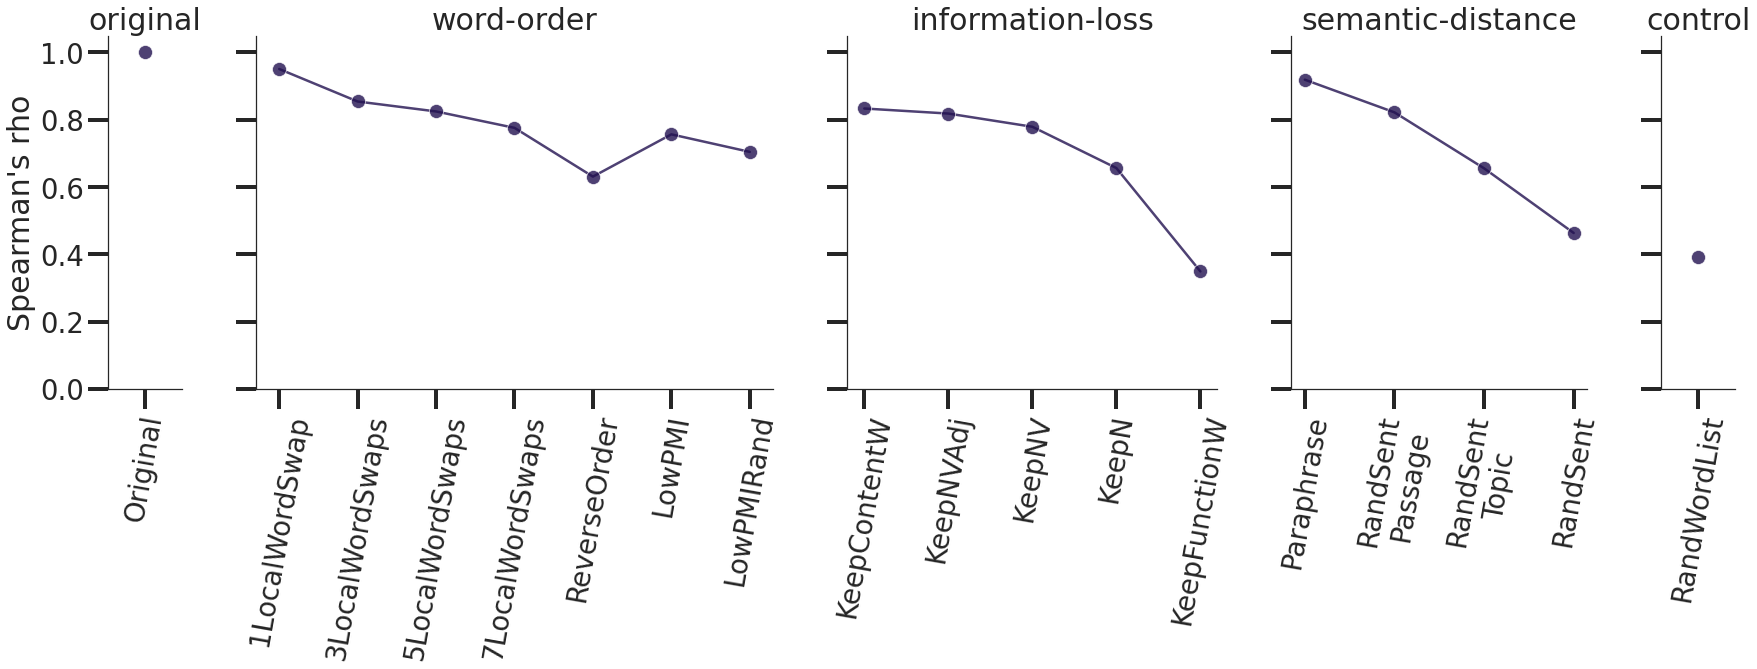

In [25]:
#get proportions for subplot width
categories = CAT2COND.keys()
props = [len(correlations_df.loc[correlations_df["category"] == cat])/len(correlations_df) for cat in categories]

palette = sns.color_palette('magma')

g = sns.FacetGrid(correlations_df, col="category", sharex=False,
                  gridspec_kws={"width_ratios": props},
                  height=10, aspect=0.5)

g.map(sns.lineplot, "condition", "Spearman correlation", alpha=0.8, markersize=14, marker="o", linewidth=2.5, color=palette[0])
g.set_xlabels("")
g.set_ylabels("Spearman's rho")
g.set(ylim=(0, 1.05))
g.set_titles(col_template="{col_name}", pad=0.1)
g.set_xticklabels(rotation=80)

g.fig.tight_layout()

plt.savefig(f'results_paper_revision/correlations2brainscore/last-layer-correlations.png', bbox_inches='tight', dpi=300)
plt.savefig(f'results_paper_revision/correlations2brainscore/last-layer-correlations.svg', bbox_inches='tight', dpi=300)

plt.show()